## 골과 높은 상관성을 지니는 요소를 파악하고, 
## 이를 바탕으로 기대 골 수를 예측하자
### (EPL 20-21 리그 데이터 기준)

#### 사용 모듈 호출

In [1]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn import linear_model
from sklearn import cluster
from sklearn import ensemble
from sklearn import svm, neighbors
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')
# 경고 문구를 잠재우는 구문

In [3]:
targetData = pd.read_csv("./EPL_20_21.csv")

In [4]:
targetData.head()

,Name,Club,Nationality,Position,Age,Matches,Starts,Mins,Goals,Assists,Passes_Attempted,Perc_Passes_Completed,Penalty_Goals,Penalty_Attempted,xG,xA,Yellow_Cards,Red_Cards
0,Mason Mount,Chelsea,ENG,"MF,FW",21,36,32,2890,6,5,1881,82.3,1,1,0.21,0.24,2,0
1,Edouard Mendy,Chelsea,SEN,GK,28,31,31,2745,0,0,1007,84.6,0,0,0.00,0.00,2,0
2,Timo Werner,Chelsea,GER,FW,24,35,29,2602,6,8,826,77.2,0,0,0.41,0.21,2,0
3,Ben Chilwell,Chelsea,ENG,DF,23,27,27,2286,3,5,1806,78.6,0,0,0.10,0.11,3,0
4,Reece James,Chelsea,ENG,DF,20,32,25,2373,1,2,1987,85.0,0,0,0.06,0.12,3,0


In [5]:
pd.set_option("display.max_rows", None)

#### 데이터 정제

In [6]:
targetData.dtypes

Name                      object
Club                      object
Nationality               object
Position                  object
Age                        int64
Matches                    int64
Starts                     int64
Mins                       int64
Goals                      int64
Assists                    int64
Passes_Attempted           int64
Perc_Passes_Completed    float64
Penalty_Goals              int64
Penalty_Attempted          int64
xG                       float64
xA                       float64
Yellow_Cards               int64
Red_Cards                  int64
dtype: object

#### 01. 포지선 정의

In [7]:
targetData.Position.value_counts(ascending=True)

FW,DF      6
DF,FW      6
MF,DF     13
DF,MF     15
MF,FW     36
GK        42
FW,MF     47
FW        81
MF       108
DF       178
Name: Position, dtype: int64

In [8]:
for i in range(0, targetData.shape[0]):
    if("DF" in targetData.Position[i]):
        targetData.Position[i] = "DF"
    if("MF" in targetData.Position[i]):
        targetData.Position[i] = "MF"

In [ ]:
# 두 포지션 이상을 겸할 수 있는 선수의 경우, DF&MF의 경우 DF를, MF&FW의 경우 MF를 기준으로 책정하여 보수적인 포지션 구분을 수행하였음

In [9]:
targetData.Position.value_counts(ascending=True)

GK     42
FW     81
MF    191
DF    218
Name: Position, dtype: int64

In [10]:
targetData["Position_new"] = np.where(targetData.Position == "GK", 1, \
                                   np.where(targetData.Position == "DF", 2, \
                                        np.where(targetData.Position == "MF", 3, 4)))

In [ ]:
# GK는 1, DF는 2, MF는 3, FW는 4의 값으로 데이터를 정제

In [61]:
sum(targetData.loc[targetData.Position_new == 1].Goals)

1

<BarContainer object of 532 artists>

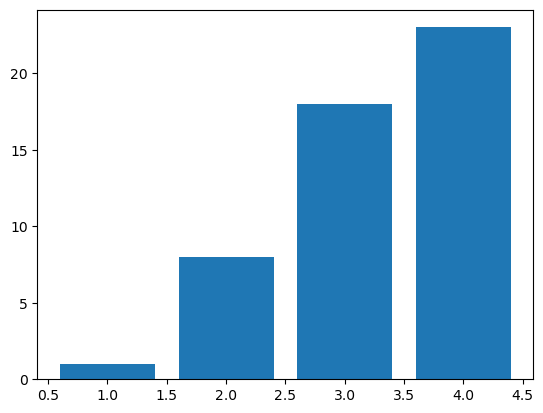

In [66]:
plt.bar(x=targetData.Position_new, height=targetData.Goals)

In [ ]:
# 포지션 별 인원 수를 표현한 차트

<AxesSubplot:xlabel='Goals', ylabel='count'>

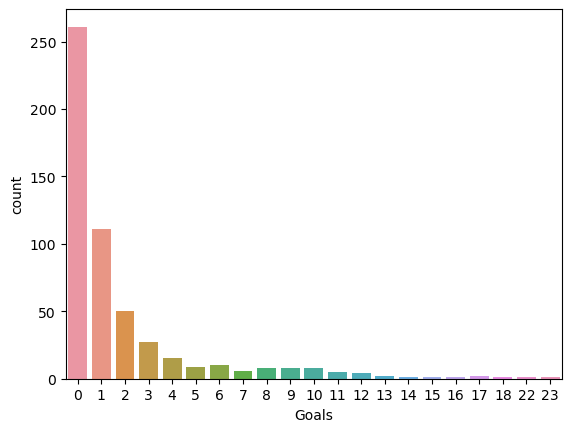

In [52]:
sns.countplot(data=targetData, x=targetData.Goals)

<AxesSubplot:xlabel='Position_new', ylabel='count'>

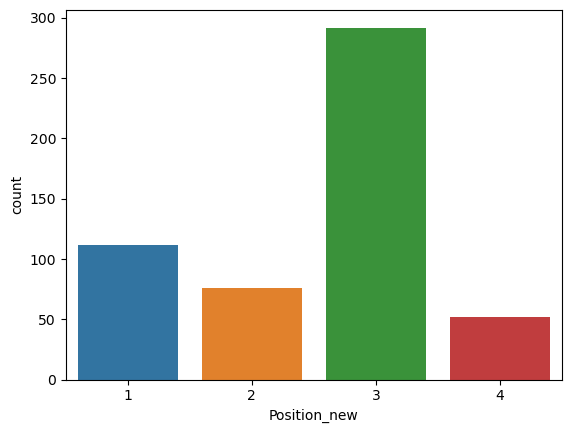

In [58]:
sns.countplot(data=targetData.Position_new, x=targetData.Goals)

In [ ]:
# 포지션 별 득점 누계를 표현한 차트

In [13]:
targetData.dtypes

Name                      object
Club                      object
Nationality               object
Position                  object
Age                        int64
Matches                    int64
Starts                     int64
Mins                       int64
Goals                      int64
Assists                    int64
Passes_Attempted           int64
Perc_Passes_Completed    float64
Penalty_Goals              int64
Penalty_Attempted          int64
xG                       float64
xA                       float64
Yellow_Cards               int64
Red_Cards                  int64
Position_new               int32
dtype: object

#### 2. 상관계수 분석

In [14]:
corrData = targetData.corr()

In [15]:
corrData

,Age,Matches,Starts,Mins,Goals,Assists,Passes_Attempted,Perc_Passes_Completed,Penalty_Goals,Penalty_Attempted,xG,xA,Yellow_Cards,Red_Cards,Position_new
Age,1.000000,0.149628,0.156387,0.158643,0.047022,0.026740,0.120244,0.122812,0.084547,0.083328,-0.056098,-0.047849,0.115191,0.065414,-0.157420
Matches,0.149628,1.000000,0.938116,0.947351,0.441977,0.508009,0.785362,0.085462,0.227929,0.234389,0.192047,0.227570,0.578093,0.168281,0.065921
Starts,0.156387,0.938116,1.000000,0.997031,0.405381,0.477704,0.853448,0.086039,0.216877,0.221418,0.072487,0.113446,0.603497,0.195383,-0.087604
Mins,0.158643,0.947351,0.997031,1.000000,0.400398,0.474677,0.855600,0.085460,0.219027,0.224115,0.075016,0.117602,0.604634,0.193038,-0.087271
Goals,0.047022,0.441977,0.405381,0.400398,1.000000,0.617831,0.201526,-0.025137,0.594730,0.590492,0.681959,0.348428,0.104413,0.057785,0.459487
Assists,0.026740,0.508009,0.477704,0.474677,0.617831,1.000000,0.393906,-0.016645,0.408459,0.411784,0.383358,0.558677,0.213691,-0.020855,0.289309
Passes_Attempted,0.120244,0.785362,0.853448,0.855600,0.201526,0.393906,1.000000,0.228393,0.149533,0.157020,-0.092535,0.105132,0.634567,0.208003,-0.179258
Perc_Passes_Completed,0.122812,0.085462,0.086039,0.085460,-0.025137,-0.016645,0.228393,1.000000,-0.024517,-0.014934,-0.035313,0.047720,0.162451,0.054068,-0.042912
Penalty_Goals,0.084547,0.227929,0.216877,0.219027,0.594730,0.408459,0.149533,-0.024517,1.000000,0.982176,0.407251,0.205417,0.057846,0.021109,0.227421
Penalty_Attempted,0.083328,0.234389,0.221418,0.224115,0.590492,0.411784,0.157020,-0.014934,0.982176,1.000000,0.420159,0.218949,0.063506,0.031073,0.231719


#### 상관계수 기준 설정

In [16]:
targetCorrRatio = [3, 4, 5, 6, 7]

In [17]:
for i in range(0, len(targetCorrRatio)):
    targetCorrRatio[i] = targetCorrRatio[i] / 10

### 대상 features 선정

In [18]:
features = [0 for i in range(0, len(targetCorrRatio))]

In [19]:
for i in range(0, len(features)):
    features[i] = list(corrData[(abs(corrData.Goals) > targetCorrRatio[i]) &\
                         (abs(corrData.Goals) != 1)].index)

In [20]:
for i in range(0, len(features)):
    print(features[i])

['Matches', 'Starts', 'Mins', 'Assists', 'Penalty_Goals', 'Penalty_Attempted', 'xG', 'xA', 'Position_new']
['Matches', 'Starts', 'Mins', 'Assists', 'Penalty_Goals', 'Penalty_Attempted', 'xG', 'Position_new']
['Assists', 'Penalty_Goals', 'Penalty_Attempted', 'xG']
['Assists', 'xG']
[]


In [ ]:
# 기준 상관계수 0.6 수준으로 features를 설정

In [21]:
features = features[3]

In [22]:
features

['Assists', 'xG']

In [ ]:
# 유의성을 지니는 features 데이터로 Assist 횟수와 xG 값을 선정하였다.

In [23]:
label = ["Goals"]

#### 3. 데이터 분리

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
trainingDataFeatures,\
testDataFeatures,\
trainingDataLabel,\
testDataLabel = train_test_split(targetData.loc[:, features], \
                                 targetData.loc[:, label], \
                                 test_size=0.3, \
                                 random_state=10)

In [ ]:
# target : test 비율은 7:3, random_state는 10만큼 설정하였다.

In [26]:
trainingDataFeatures = trainingDataFeatures.reset_index(drop=True, inplace=False)
trainingDataLabel = trainingDataLabel.reset_index(drop=True, inplace = False)
testDataFeatures = testDataFeatures.reset_index(drop=True, inplace=False)
testDataLabel = testDataLabel.reset_index(drop=True, inplace=False)

#### 4. 모델 선언 및 학습

In [27]:
tree_regressor_method = tree.DecisionTreeRegressor(random_state=10)
# DecisionTreeClassifier 모델을 호출

In [28]:
ensemble_regressor_method = ensemble.RandomForestRegressor(random_state = 10)
# RandomForestClassifier 모델을 호출

In [29]:
knnModel = neighbors.KNeighborsRegressor(n_neighbors=3)
# KneighborsClassifier 모델을 호출

In [30]:
svmModel = svm.SVR(C=1)
# SVC 모델을 호출

In [31]:
tree_regressor_model = tree_regressor_method.fit(X = trainingDataFeatures, y = trainingDataLabel)
ensemble_regressor_model = ensemble_regressor_method.fit(X = trainingDataFeatures, y = trainingDataLabel)
knn_model = knnModel.fit(X = trainingDataFeatures, y = trainingDataLabel)
svm_model = svmModel.fit(X = trainingDataFeatures, y = trainingDataLabel)

In [32]:
treeCM = tree_regressor_model.predict(testDataFeatures)

In [33]:
ensembleCM = ensemble_regressor_model.predict(testDataFeatures)

In [34]:
knnCM = knn_model.predict(testDataFeatures)

In [35]:
svmCM = svm_model.predict(testDataFeatures)

#### 6. 정답 수치와 비교

In [36]:
testDataLabel["TREE_PRE"] = treeCM

In [37]:
testDataLabel["ENSEMBLE_PRE"] = ensembleCM

In [38]:
testDataLabel["KNN_PRE"] = knnCM

In [39]:
testDataLabel["SVM_PRE"] = svmCM

In [40]:
testDataLabel.head()

,Goals,TREE_PRE,ENSEMBLE_PRE,KNN_PRE,SVM_PRE
0,0,0.014085,0.012487,0.000000,0.077195
1,0,0.014085,0.012487,0.000000,0.077195
2,0,0.014085,0.012487,0.000000,0.077195
3,2,1.250000,1.238754,1.333333,0.597654
4,0,16.000000,11.330000,5.666667,1.307329


#### 7. 신뢰도 확인

In [41]:
maeList = [0 for i in range(1, len(testDataLabel.columns))]
mseList = [0 for i in range(1, len(testDataLabel.columns))]

In [42]:
for i in range(0, len(maeList)):
    maeList[i] = mean_absolute_error(y_true=testDataLabel["Goals"], y_pred=testDataLabel[testDataLabel.columns[i+1]])
    mseList[i] = mean_squared_error(y_true=testDataLabel["Goals"], y_pred=testDataLabel[testDataLabel.columns[i+1]])

In [43]:
maeList

[1.2663772216633131, 1.228224875731478, 1.2791666666666668, 1.3149477125411542]

In [44]:
mseList

[6.531415029714111, 5.249713507764271, 5.213888888888889, 6.981749465118057]

In [ ]:
# MAE는 오차 절댓값의 합, MSE는 MAE의 제곱 합이므로, 가장 평가 기준 요소가 작은 값을 기록한 RandomForestRegressor 모델이 가장 정확한 분석을 수행하였다고 판단한다.

#### 테스트

In [45]:
playerDf = pd.DataFrame([[3, 0.7]], columns=["Assist", "xG"])

In [46]:
playerDf

,Assist,xG
0,3,0.7


In [48]:
pd.DataFrame(ensemble_regressor_model.predict(playerDf), columns=["Expected_Goals"], index=["count"])

,Expected_Goals
count,10.75


In [ ]:
# Assist 3개, xG값 0.7인 선수의 경우, 약 10.75 개의 기대 득점을 예측하였다.